In [1]:
import os
import numpy as np
import imageio
import cv2
import pandas as pd
face_path = './yalefaces/'
X = []
y_hum = []
y_exp = [] 
#如subject02.centerlight，其y_hum为02，y_exp为centerlight
        
for file in os.listdir(face_path):
    infos = file.split('.')
    hum = infos[0].split('t')[-1]
    ## label starts from 0
    hum = int(hum) - 1
    exp = infos[1]
    y_hum.append(hum)
    y_exp.append(exp)
    # print(exp)
    ## image
    im_fn = os.path.join(face_path, file)
    gif = imageio.mimread(im_fn)
    gif = gif[0]
    gif = np.array(gif)
    X.append(gif)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
X = np.array(X)
n_class = max(y_hum) + 1
## flatten
X = X.reshape((X.shape[0], -1))

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt  
from matplotlib.colors import Colormap

In [4]:
#分训练集和测试集，构建标签，只作为样例
x_train, x_test, y_train, y_test = train_test_split(X, y_hum, train_size = 0.6, random_state = 0)
y_one_hot = label_binarize(y_test, np.arange(n_class))  


/home/zeppelin/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [5]:
X_image=X.reshape(164,243,320)

In [6]:
image_array=X_image
Eimage_array=np.zeros_like(image_array[0],dtype=float)
for i in range(len(image_array)):
    Eimage_array+=image_array[i]
Eimage_array/=len(image_array)
image_centered=image_array-Eimage_array

## 2D PCA L2实现

In [7]:
def PCA_2D(image_array):
    Eimage_array=np.zeros_like(image_array[0],dtype=float)
    for i in range(len(image_array)):
        Eimage_array+=image_array[i]
    Eimage_array/=len(image_array)
    image_centered=image_array-Eimage_array
    G_t=np.zeros((image_array[0].shape[1],image_array[0].shape[1]))
    for i in range(len(image_array)):
        G_t+=image_centered[i].T@image_centered[i]
    G_t/=len(image_array)
    w_G_t,v_G_t=np.linalg.eigh(G_t)
    return (w_G_t[::-1],v_G_t[:,::-1])

In [8]:
PCA_2D_L2_eigenvalues,PCA_2D_L2_vector=PCA_2D(X_image)

## 2D PCA L1实现

In [9]:
def PCA_2D_L1_one_dimension(image_centered,max_turn):
    u_t=np.random.rand(image_centered.shape[-1])-0.5
    u_t/=np.sqrt(u_t@u_t.T)
    while True:
        turn_count=0
        tmp=image_centered@u_t
        polarity=np.zeros(image_centered.shape[:2],dtype=int)
        polarity[tmp>0]=1
        polarity[tmp<=0]=-1
        u_t_new=sum([polarity[i]@image_centered[i] for i in range(len(polarity))])
        u_t_new=u_t_new/np.sqrt(u_t_new@u_t_new.T)
        delta=u_t_new-u_t
        if ((delta.max()-delta.min())<1e-5):
            break 
        if turn_count>=max_turn:
            print('Max turn')
            break
        turn_count+=1
        u_t=u_t_new
    return u_t_new

In [10]:
def PCA_2D_L1(image_centerer,max_turn,dimension):
    p_vectors=[PCA_2D_L1_one_dimension(image_centered,max_turn)]
    last_image=image_centered
    for i in range(1,dimension):
        last_v=p_vectors[-1].reshape(last_image.shape[-1],1)
        new_image=last_image-last_image@last_v@last_v.T
        last_image=new_image
        p_vectors.append(PCA_2D_L1_one_dimension(new_image,max_turn))
    return np.array(p_vectors).T

In [11]:
import time
start=time.time()
PCA_2D_L1_vector=PCA_2D_L1(image_centered,50,50)
print(time.time()-start)

87.76894998550415


In [14]:
np.save('PCA_2D_L1_vector.npy',PCA_2D_L1_vector)

In [15]:
pca_1D=PCA(n_components=50)
pca_1D.fit(image_centered.reshape(164,-1))
image_1D_pc=pca_1D.transform(image_centered.reshape(164,-1))

In [19]:
PCA_1D_L2_vectors=pca_1D.components_.T

## 2D PCA结果分析:

特征值的大小随次序的变化图如下, 可以看出降维的合理性

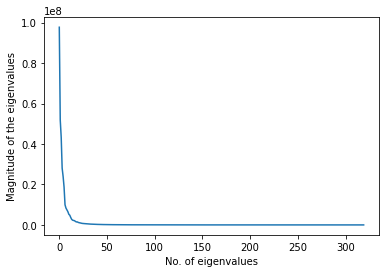

In [23]:
plt.plot(range(320),PCA_2D_L2_eigenvalues)
plt.xlabel('No. of eigenvalues')
plt.ylabel('Magnitude of the eigenvalues')
plt.show()

计算前n个特征值平方和所占百分比的值, 可以发现前4个特征值就达到了90%

[0.5894474265705719, 0.7555047061929593, 0.8715204427530215, 0.9200895171663219, 0.9556066057248422, 0.9772156666187725, 0.9833452040379225, 0.9876129554845797, 0.9910434919642287]


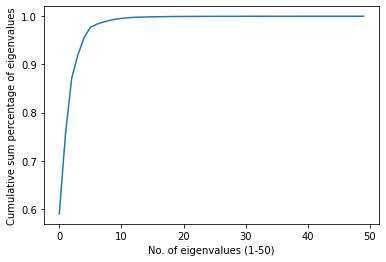

In [24]:
eigenvalues_percent=np.square(PCA_2D_L2_eigenvalues)/np.sum(np.square(PCA_2D_L2_eigenvalues))
eigenvalues_percent_sum=[0]
for i in eigenvalues_percent:
    eigenvalues_percent_sum.append(eigenvalues_percent_sum[-1]+i)
print(eigenvalues_percent_sum[1:10])
N=50
plt.plot(range(N),eigenvalues_percent_sum[1:N+1])
plt.xlabel('No. of eigenvalues (1-'+str(N)+')')
plt.ylabel('Cumulative sum percentage of eigenvalues')
plt.show()

基于2D PCA的图像重构, 分别采取2,4,6,8,10个特征值

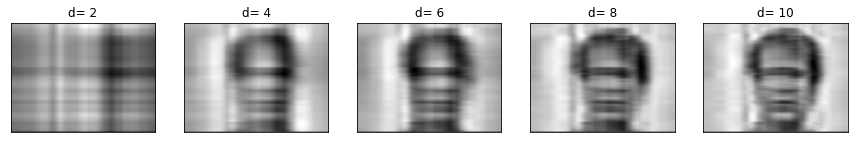

In [25]:
reconstructed=[2,4,6,8,10]
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    X_image_eigenvector=PCA_2D_L2_vector[:,:reconstructed[i]]
    tmp=X_image[0]@X_image_eigenvector@X_image_eigenvector.T
    plt.imshow(tmp,cmap=plt.cm.gray)
    plt.title('d= '+str(reconstructed[i]))
    plt.xticks(())
    plt.yticks(())
# plt.savefig('reconstructed images based on 2DPCA',dpi=200)
plt.show()

与1D PCA比较:

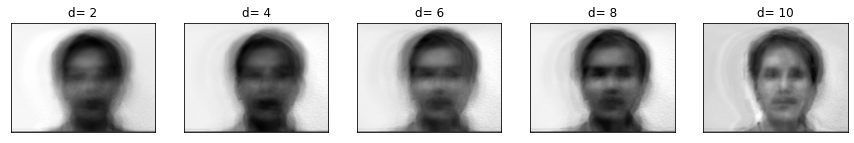

In [30]:
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    ttt=reconstructed[i]
    tmp=(image_1D_pc[0][:ttt]@PCA_1D_L2_vectors[:,:ttt].T).reshape(243,320)+Eimage_array
    plt.imshow(tmp,cmap=plt.cm.gray)
    plt.title('d= '+str(reconstructed[i]))
    plt.xticks(())
    plt.yticks(())
# plt.savefig('reconstructed images based on 2DPCA',dpi=200)
plt.show()

 2D PCA图像重构中第1,2,4,7,10个特征得到的子图:

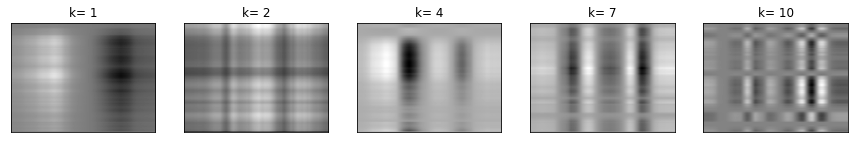

In [31]:
reconstructed_sub=[1,2,4,7,10]
plt.figure(figsize=(15,6))
for i in range(5):
    plt.subplot(1,5,i+1)
    X_image_eigenvector=PCA_2D_L2_vector[:,reconstructed_sub[i]-1].reshape(320,1)
    tmp=X_image[0]@X_image_eigenvector@X_image_eigenvector.T
    plt.imshow(tmp,cmap=plt.cm.gray)
    plt.title('k= '+str(reconstructed_sub[i]))
    plt.xticks(())
    plt.yticks(())
plt.savefig('Some reconstructed subimages are shown in inverse color.',dpi=200)
plt.show()

## 样本分布可视化对比

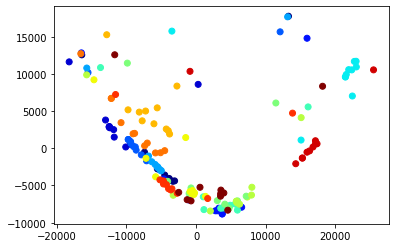

In [32]:
# 1D PCA
fig,ax=plt.subplots()
ax.scatter(image_1D_pc[:,0],image_1D_pc[:,1],c=y_hum,cmap='jet')
plt.show()

对2D PCA得到的前4个主成分矢量进行PCA处理降到二维,进行可视化

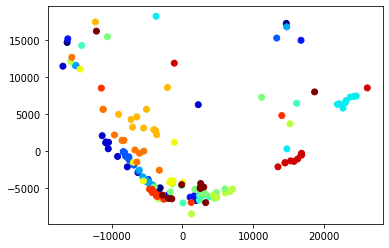

In [33]:
# 取2DPCA前4个特征向量
U=PCA_2D_L2_vector[:,:4]
X_principal_componet=X_image@U
X_pc1=X_principal_componet.reshape(164,243*4)
X_pc1-=(sum(X_pc1)/len(X_pc1))
pca=PCA(n_components=2)
pca.fit(X_pc1)
Pca_1D=pca.transform(X_pc1)
fig,ax=plt.subplots()
ax.scatter(Pca_1D[:,0],Pca_1D[:,1],c=y_hum,cmap='jet')
plt.show()

对2D PCA L1得到的前4个主成分矢量进行PCA处理降到二维,进行可视化

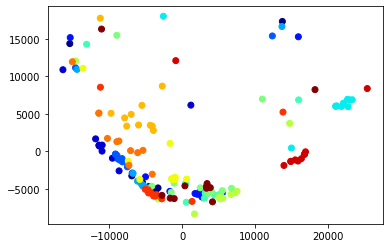

In [34]:
U=PCA_2D_L1_vector[:,:4]
X_principal_componet=X_image@U
X_pc1=X_principal_componet.reshape(164,243*4)
X_pc1-=(sum(X_pc1)/len(X_pc1))
pca=PCA(n_components=2)
pca.fit(X_pc1)
Pca_1D=pca.transform(X_pc1)
fig,ax=plt.subplots()
ax.scatter(Pca_1D[:,0],Pca_1D[:,1],c=y_hum,cmap='jet')
plt.show()

## 聚类算法效果对比

In [35]:
from sklearn.cluster import KMeans

计算召回率/准确率/F值:

In [36]:
def precision_recall_F(P,C):
    size=len(set(P))
    P_C_count=np.zeros((size,size))
    P_count=np.zeros((size,))
    C_count=np.zeros((size,))
    for i in range(len(P)):
        P_C_count[C[i]][P[i]]+=1
        P_count[P[i]]+=1
        C_count[C[i]]+=1
    recall=np.zeros((size,size))
    precision=np.zeros((size,size))
    F_measure=np.zeros((size,size))
    for i in range(size):
        for j in range(size):
            recall[i][j]=P_C_count[i][j]/P_count[j]
            precision[i][j]=P_C_count[i][j]/C_count[i]
            if(recall[i][j] and precision[i][j]):
                F_measure[i][j]=2*precision[i][j]*recall[i][j]/(precision[i][j]+recall[i][j])
            else:
                F_measure[i][j]=0
    F=sum([P_count[i]/len(P)*F_measure[:,i].max() for i in range(size)])
    return (precision,recall,F_measure,F)

1D L2 PCA

In [38]:
F_score_1D=[]
for i in range(10):
    X_image_cluster=KMeans(n_clusters=15,init='k-means++').fit(image_1D_pc)
    P_R_F=precision_recall_F(y_hum,X_image_cluster.labels_)
    F_score_1D.append(P_R_F[-1])
print(min(F_score_1D),max(F_score_1D))

0.6158908749635927 0.7111670382403239


2D L2 PCA

In [39]:
F_score_2D_L2=[]
for i in range(10):
    U=PCA_2D_L2_vector[:,:4]
    X_principal_componet=X_image@U
    X_image_cluster=KMeans(n_clusters=15,init='k-means++').fit(X_principal_componet.reshape(164,243*4))
    P_R_F=precision_recall_F(y_hum,X_image_cluster.labels_)
    F_score_2D_L2.append(P_R_F[-1])
print(min(F_score_2D_L2),max(F_score_2D_L2))

0.658179520984399 0.7129843067114302


2D L1 PCA

In [41]:
F_score_L1=[]
for i in range(10):
    U=PCA_2D_L1_vector[:,:4]
    X_principal_componet=X_image@U
    X_image_cluster=KMeans(n_clusters=15,init='k-means++').fit(X_principal_componet.reshape(164,243*4))
    P_R_F=precision_recall_F(y_hum,X_image_cluster.labels_)
    F_score_L1.append(P_R_F[-1])
print(min(F_score_L1),max(F_score_L1))

0.6401384871415129 0.7112819166453639


分类对比（使用KNN）

In [43]:
from sklearn import neighbors,datasets
x_image_train=x_train.reshape(98,243,320)
x_image_test=x_test.reshape(x_test.shape[0],243,320)

In [58]:
error_1D=[[] for j in range(20)]
for j in range(20):
    U=PCA_1D_L2_vectors[:,:(j+1)]
    x_train_pc=x_train@U
    x_test_pc=x_test@U
    for i in range(1,31):
        clf=neighbors.KNeighborsClassifier(i)
        clf.fit(x_train_pc,y_train)
        z=clf.predict(x_test_pc)
        error_1D[j].append(1-np.sum(z==y_test)/len(y_test))

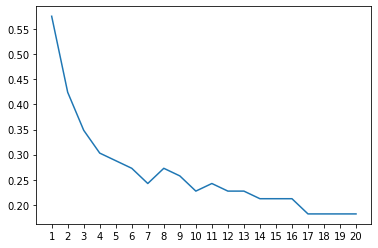

In [59]:
plt.plot(range(1,21),[min(error_1D[i]) for i in range(20)])
plt.xticks(range(1,21))
plt.show()

In [61]:
error_1D[16][0]

0.18181818181818177

2D PCA L2:

In [47]:
error_2D_L2=[[] for j in range(10)]
for j in range(10):
    U=PCA_2D_L2_vector[:,:(j+1)]
    x_train_pc=x_image_train@U
    x_test_pc=x_test.reshape(66,243,320)@U
    for i in range(1,31):
        clf=neighbors.KNeighborsClassifier(i)
        clf.fit(x_train_pc.reshape(98,-1),y_train)
        z=clf.predict(x_test_pc.reshape(66,-1))
        error_2D_L2[j].append(1-np.sum(z==y_test)/len(y_test))

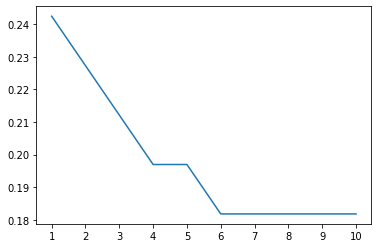

In [51]:
plt.plot(range(1,11),[min(error_2D_L2[i]) for i in range(10)])
plt.xticks(range(1,11))
plt.show()

In [65]:
error_2D_L2[5][0]

0.18181818181818177

2D PCA L1

In [62]:
error_2D_L1=[[] for j in range(10)]
for j in range(10):
    U=PCA_2D_L1_vector[:,:(j+1)]
    x_train_pc=x_image_train@U
    x_test_pc=x_test.reshape(66,243,320)@U
    for i in range(1,31):
        clf=neighbors.KNeighborsClassifier(i)
        clf.fit(x_train_pc.reshape(98,-1),y_train)
        z=clf.predict(x_test_pc.reshape(66,-1))
        error_2D_L1[j].append(1-np.sum(z==y_test)/len(y_test))

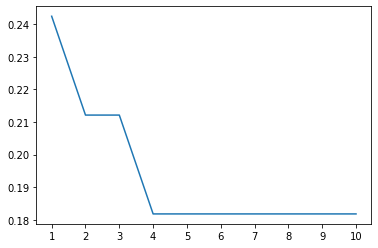

In [63]:
plt.plot(range(1,11),[min(error_2D_L1[i]) for i in range(10)])
plt.xticks(range(1,11))
plt.show()

In [64]:
error_2D_L1[4][0]

0.18181818181818177

计算图像重构损失

In [66]:
def error(image_centered,projection_matrix):
    tmp=0
    for i in image_centered:
        tmp+=np.sqrt(np.square(i-i@projection_matrix@projection_matrix.T).sum())
    tmp/=image_centered.shape[0]
    return tmp

In [67]:
error_PCA_L2=[error(image_centered.reshape(164,-1),PCA_1D_L2_vectors[:,:i]) for i in range(1,51)]

In [76]:
error_PCA_2D_L2=[error(image_centered,PCA_2D_L2_vector[:,:i]) for i in range(1,51)]

In [77]:
error_PCA_L1=[error(image_centered,PCA_2D_L1_vector[:,:i]) for i in range(1,51)]

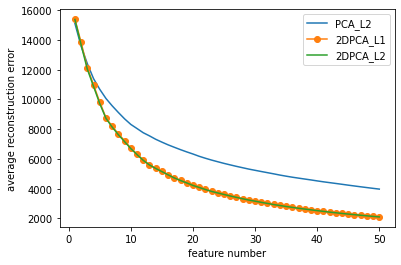

In [78]:
plt.plot(range(1,51),error_PCA_L2)
plt.plot(range(1,51),error_PCA_L1,'o-')
plt.plot(range(1,51),error_PCA_2D_L2)
plt.xlabel('feature number')
plt.ylabel('average reconstruction error')
plt.legend(['PCA_L2', '2DPCA_L1', '2DPCA_L2'])